In [33]:
import os
import cv2
import glob
import tqdm
import time
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf

In [2]:
physical_device = tf.config.experimental.list_physical_devices('GPU')
print(f'Number of available GPU: {len(physical_device)}')

try:
    tf.config.experimental.set_memory_growth(physical_device[0], True)
except:
    print('No GPU detected')

Number of available GPU: 1


In [3]:
training_path = r'.\Pneumonia\train'
validation_path = r'.\Pneumonia\test'
testing_path = r'.\Pneumonia\val'

<h3>Data Visualization</h3>

In [4]:
files_normal = glob.glob(os.path.join(training_path, 'NORMAL') + r'\*.*')
files_pneunomia=  glob.glob(os.path.join(training_path, 'PNEUMONIA') + r'\*.*')

images = []
for file in files_normal[:5]:
    img = cv2.imread(file)
    img = cv2.resize(img, (200, 200))
    images.append(img)

for file in files_pneunomia[:5]:
    img = cv2.imread(file)
    img = cv2.resize(img, (200, 200))
    images.append(img)

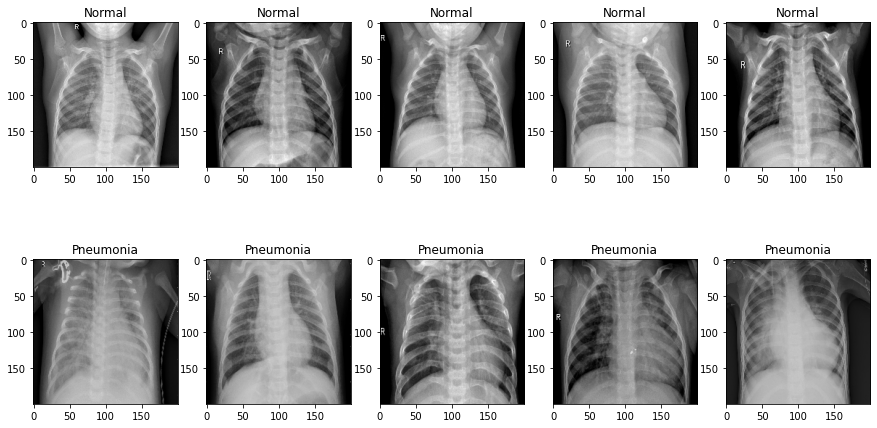

In [5]:
fig = plt.figure(figsize=(15, 8))
i = 1
for img in images:
    ax = fig.add_subplot(2, 5, i)
    ax.set_title('Normal')
    if (i > 5):
        ax.set_title('Pneumonia')
    ax.imshow(img)
    i += 1

<h4>1. OpenCV pipeline<h4>

In [6]:
def createDataframe(path):
    files_normal = glob.glob(os.path.join(path, 'NORMAL') + r'\*.*')
    files_pneunomia = glob.glob(os.path.join(path, 'PNEUMONIA') + r'\*.*')
    
    files_normal = files_normal
    files_pneunomia = files_pneunomia
    
    def transformImage(file_name: str):
        img = cv2.imread(file_name)
        img = cv2.resize(img, (200, 200))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if (img.shape[2] == 1):
            print('Anomaly detected!!!')
        return img

    images = []
    labels = []
    for file in tqdm.tqdm(files_normal):
        img = transformImage(file)
        images.append(img)
        labels.append(0)
    for file in tqdm.tqdm(files_pneunomia):
        img = transformImage(file)
        images.append(img)
        labels.append(1)

    dataframe = pd.DataFrame()
    dataframe['images'] = images
    dataframe['labels'] = labels
    dataframe = dataframe.sample(frac=1).reset_index(drop=True)
    return dataframe

dataframe_training = createDataframe(training_path)
dataframe_validation = createDataframe(validation_path)

100%|██████████| 390/390 [00:09<00:00, 40.85it/s]


In [7]:
X_train, y_train = np.stack(dataframe_training['images'] / 255).astype('float32'), dataframe_training['labels']
X_test, y_test = np.stack(dataframe_validation['images'] / 255).astype('float32'), dataframe_validation['labels']

In [8]:
X_train = np.reshape(X_train, (X_train.shape[0], 200, 200, 3))
X_test = np.reshape(X_test, (X_test.shape[0], 200, 200, 3))

In [9]:
def XceptionModel():
    base_model = tf.keras.applications.Xception(include_top=False, weights='imagenet', input_shape=(200, 200, 3))
    output_layer = base_model.layers[-1].output
    output_layer = tf.keras.layers.GlobalMaxPooling2D()(output_layer)
    output_layer = tf.keras.layers.Flatten()(output_layer)
    output_layer = tf.keras.layers.Dropout(0.4)(output_layer)
    
    base_model = tf.keras.models.Model(inputs=base_model.inputs, outputs=output_layer)
    
    for layer in base_model.layers:
        layer.trainable = False
        
    model = tf.keras.models.Sequential()
    model.add(base_model)
    model.add(tf.keras.layers.Dense(1000, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(500, activation='relu'))
    model.add(tf.keras.layers.Dropout(0.4))
    model.add(tf.keras.layers.Dense(100, activation='relu'))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    
    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.01), 
                      loss=tf.keras.losses.BinaryCrossentropy(),
                         metrics=['accuracy'])
    
    return model

In [10]:
xception = XceptionModel()

In [11]:
class TimeLogger(tf.keras.callbacks.Callback):
    def __init__(self, name:str):
        self.log_name = name
        self.start_time = None
        self.log_time = []
        self.log_epoch = []
        
    def on_epoch_begin(self, epoch, logs=None):
        self.start_time = time.time()
    
    def on_epoch_end(self, epoch, logs=None):
        self.log_epoch.append(epoch)
        self.log_time.append(time.time() - self.start_time)
        
    def on_train_end(self, logs=None):
        dataframe_log = pd.DataFrame()
        dataframe_log['epochs'] = np.array(self.log_epoch) 
        dataframe_log['duration'] = np.array(self.log_time)
        dataframe_log.to_csv('log_duration\\' + self.log_name + '.csv', index=False)

In [12]:
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1, min_lr=1e-7)

In [17]:
%%time
duration_callback = TimeLogger('OpenCV_duration_log')
history = xception.fit(X_train, y_train,
                          epochs=20, batch_size=64,
                              validation_data=(X_test, y_test),
                                  callbacks=[early_stopping, reduce_lr, duration_callback], verbose=1,
                                      use_multiprocessing=True)
pd.DataFrame.from_dict(history.history).to_csv(r'log_history\history_open_cv.csv', index=False)
tf.keras.models.save_model(xception, r'log_weights\model_opencv.h5')

Epoch 1/20
32/32 [==============================] - 68s 2s/step - loss: 0.1770 - accuracy: 0.9355 - val_loss: 0.3769 - val_accuracy: 0.8590
Epoch 2/20
32/32 [==============================] - 68s 2s/step - loss: 0.1576 - accuracy: 0.9450 - val_loss: 0.5163 - val_accuracy: 0.8462
Epoch 3/20
32/32 [==============================] - 67s 2s/step - loss: 0.1691 - accuracy: 0.9470 - val_loss: 0.4562 - val_accuracy: 0.8269
Epoch 4/20
32/32 [==============================] - 42s 1s/step - loss: 0.1600 - accuracy: 0.9505 - val_loss: 0.4413 - val_accuracy: 0.8590
Epoch 5/20
32/32 [==============================] - 46s 1s/step - loss: 0.1291 - accuracy: 0.9535 - val_loss: 0.5768 - val_accuracy: 0.8381
Epoch 6/20
32/32 [==============================] - 40s 1s/step - loss: 0.1298 - accuracy: 0.9605 - val_loss: 0.4852 - val_accuracy: 0.8542
Epoch 7/20
32/32 [==============================] - 67s 2s/step - loss: 0.1226 - accuracy: 0.9560 - val_loss: 0.5285 - val_accuracy: 0.8413
Epoch 8/20
32/32 [==